In [1]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib as mpl
import matplotlib
import seaborn as sns
import jax
import sys
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '../')
from plotting_helper_funcs import *
from utils import *

rng = np.random.default_rng(seed=1234)

model_info = json.load(open('../param_est/model_info.json', 'r'))
model_names = list(model_info.keys())
display_names = [model_info[model]['display_name'] for model in model_names]

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# this one gets to 10 colors by removing the darkest purple
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']

colors = get_color_pallette()
colors.remove(colors[-4]) # remove the second to last color, because we only have 10 models

#### Load in full Keyes et al. data

In [2]:
# load in the full data
data = {'CYTO':{'inputs':None, 'data':None,'data_std':None, 'times':None},
    'PM':{'inputs':None, 'data':None,'data_std':None, 'times':None}}
data['CYTO']['inputs'], data['CYTO']['data'], data['CYTO']['data_std'], \
    data['CYTO']['times'] = load_data_json('../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO.json', data_std=True, time=True)
data['PM']['inputs'], data['PM']['data'], data['PM']['data_std'], \
    data['PM']['times'] = load_data_json('../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM.json', data_std=True, time=True)
data_time_to_mins = 60

#### Load in all posterior data and samples

In [3]:
# big dictionary to store all the data and access throughout the notebook
training_data = {'40min':{},'30min':{},'20min':{},'10min':{}}
param_post_samples = {'40min':{},'30min':{},'20min':{},'10min':{}}
post_pred_samples = {'40min':{},'30min':{},'20min':{},'10min':{}}
post_samples = {'40min':{},'30min':{},'20min':{},'10min':{}}
log_marg_likes = {'40min':{},'30min':{},'20min':{},'10min':{}}
SAM40_pred_samples = {'40min':{},'30min':{},'20min':{},'10min':{}}
SAM40_post_pred_samples = {}

for time_len in ['', '_30min', '_20min', '_10min']:
    datadir = '../../../results/MAPK/param_est/Keyes_2020_data'+time_len+'/'
    savedir = '../../../results/MAPK/mmi/Keyes_2020_data'+time_len+'/'

    # load in the training data
    if time_len == '':
        training_data['40min'] = data
    else:
        data_train = {'CYTO':{'inputs':None, 'data':None,'data_std':None, 'times':None},
            'PM':{'inputs':None, 'data':None,'data_std':None, 'times':None}}
        for compartment in ['CYTO','PM']:
            data_train[compartment]['inputs'], data_train[compartment]['data'], data_train[compartment]['data_std'], \
                data_train[compartment]['times'] = load_data_json('../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-'+compartment+'-'+time_len.strip('_')+'.json', data_std=True, time=True)
        # store in big dictionary 
        training_data[time_len.strip('_')] = data_train
        
        data_time_to_mins = 60

    # if savedir does not exist, create it
    if not os.path.exists(savedir):
        os.makedirs(savedir)

    idata = {'CYTO':{},'PM':{}}
    post_pred_sampl = {'CYTO':{},'PM':{}}
    post_sampl = {'CYTO':{},'PM':{}}
    sample_times = {'CYTO':{},'PM':{}}
    ss = {'CYTO':{},'PM':{}}
    log_marginal_likes = {'CYTO':[],'PM':[]}

    for model in model_names:
        for compartment in ['CYTO','PM']:
            idata[compartment][model], ss[compartment][model], sample_times[compartment][model] = load_smc_samples_to_idata(datadir+compartment+'/' + model + '/' + model +'_smc_samples.json', sample_time=True)
            post_pred_sampl[compartment][model] = np.load(datadir+compartment+'/' + model + '/' + model +'_posterior_predictive_samples.npy')
            post_sampl[compartment][model] = np.load(datadir+compartment+'/' + model + '/traj_predict.npy')
            
            if model == 'hornberg_2005':
                # Hornberg 2005 only has 800 posterior predictive samples, so we duplicate and randomly permute them to get 2000
                H_2005_posts = [post_pred_sampl[compartment]['hornberg_2005'] for _ in range(3)]
                H_2005_post = np.vstack(H_2005_posts)
                post_pred_sampl[compartment]['hornberg_2005'] = H_2005_post[rng.permutation(np.arange(2000))]

            # now log marginal likelihoods
            _log_marg_like = ss[compartment][model]['log_marginal_likelihood']
            if len(_log_marg_like) == 1:
                log_marginal_likes[compartment].append(np.mean([chain[-1] for chain in _log_marg_like[0]]))
            else:
                log_marginal_likes[compartment].append(np.mean([chain[-1] for chain in _log_marg_like]))
        
    if time_len == '': # in this case some of the posterior predictive samples need to be modified because they are not the same length
        # shin has 4000 so downsample to 2000
        idxs = rng.choice(np.arange(4000), size=2000, replace=False)
        post_pred_sampl['CYTO']['shin_2014'] = post_pred_sampl['CYTO']['shin_2014'][idxs]
        post_pred_sampl['PM']['shin_2014'] = post_pred_sampl['PM']['shin_2014'][idxs]

    # load in the SAM40 posterior samples
    with open(datadir+'SAM40_predictions.json', "r") as json_file:
        SAM40_pred = json.load(json_file)

    # store in the big dictionary
    if time_len == '':
        key = '40min'

        # load in the SAM40 posterior predictive samples
        with open(datadir+'SAM40_post_pred.json', "r") as json_file:
            SAM40_post_pred = json.load(json_file)
    else:
        key = time_len.strip('_')

    param_post_samples[key] = idata
    post_pred_samples[key] = post_pred_sampl
    post_samples[key] = post_sampl
    log_marg_likes[key] = log_marginal_likes
    SAM40_pred_samples[key] = SAM40_pred
    SAM40_post_pred_samples = SAM40_post_pred
    

#### Compute MMI weights, ELPPD estimates and model probabilities

In [4]:
# big dictionary to store all weights
mmi_weights = {'40min':{},'30min':{},'20min':{},'10min':{}}
elpd_ests = {'40min':{},'30min':{},'20min':{},'10min':{}}

for time_len in ['', '_30min', '_20min', '_10min']:
    if time_len == '':
        key = '40min'
    else:
        key = time_len.strip('_')
    ##### Run arviz model comparison ######
    weights = {'CYTO':{'waic_pbma':{},'waic_stack':{},'loo_pbma':{},'loo_stack':{},'bma':{}},
               'PM':{'waic_pbma':{},'waic_stack':{},'loo_pbma':{},'loo_stack':{},'bma':{}}}
    elppd = {'CYTO':{'waic_pbma':{},'loo_pbma':{}},
               'PM':{'waic_pbma':{},'loo_pbma':{}}}

    for compartment in ['CYTO','PM']:
        compare_data_waic_pbma = az.compare(param_post_samples[key][compartment], ic='waic', method='BB-pseudo-BMA', seed=rng)
        weights[compartment]['waic_pbma'] = dict(compare_data_waic_pbma['weight'])
        elppd[compartment]['waic_pbma'] = dict(compare_data_waic_pbma['elpd_waic'])

        compare_data_loo_pbma = az.compare(param_post_samples[key][compartment], ic='loo', method='BB-pseudo-BMA', seed=rng)
        weights[compartment]['loo_pbma'] = dict(compare_data_loo_pbma['weight'])
        elppd[compartment]['loo_pbma'] = dict(compare_data_loo_pbma['elpd_loo'])

        compare_data_waic_stack = az.compare(param_post_samples[key][compartment], ic='waic', method='stacking', seed=rng)
        weights[compartment]['waic_stack'] = dict(compare_data_waic_stack['weight'])

        compare_data_loo_stack = az.compare(param_post_samples[key][compartment], ic='loo', method='stacking', seed=rng)
        weights[compartment]['loo_stack'] = dict(compare_data_loo_stack['weight'])

    ##### Compute model probabilities ######
        # function to compute log sum exponential in a numerically stable way
    def logsumexp(x):
        c = np.max(x)
        return c + np.log(np.sum(np.exp(x - c)))

    def weight_with_logsumexp(log_values):
        return np.exp(log_values - logsumexp(log_values))

    for compartment in ['CYTO','PM']:
        n_models = len(log_marg_likes[key][compartment])
        prior_prob = 1/n_models
        model_probs = weight_with_logsumexp(np.log(prior_prob)+log_marg_likes[key][compartment])
        m_probs = {}
        for i, model in enumerate(model_names):
            m_probs[model] = model_probs[i]

        weights[compartment]['bma'] = m_probs

    # store in big dictionary
    mmi_weights[key] = weights
    elpd_ests[key] = elppd


/Users/natetest/miniforge3/envs/pymc/lib/python3.13/site-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if

#### Plot ELPPD estimates and model probabilities

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

_30min


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

_20min


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)


_10min


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1177076588.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/Users/natetest/Library/CloudStorage/Dropbox/Mac (2)/Documents/phd/research/Project_4_multimodel-inference/src/MAPK/multimodel_inference/../plotting_helper_funcs.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider usi

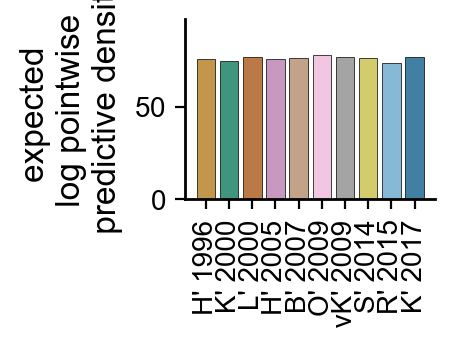

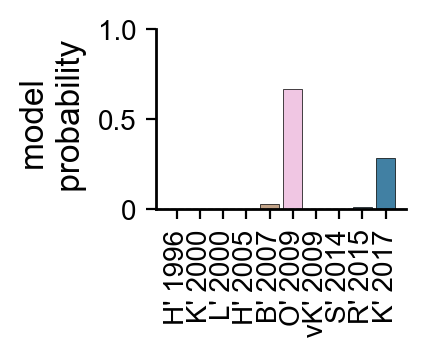

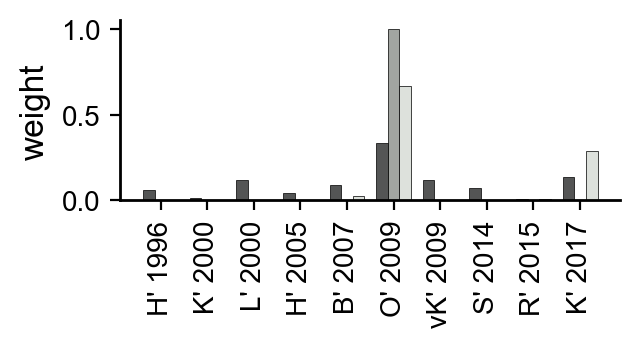

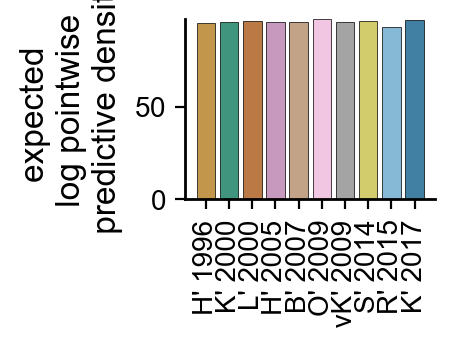

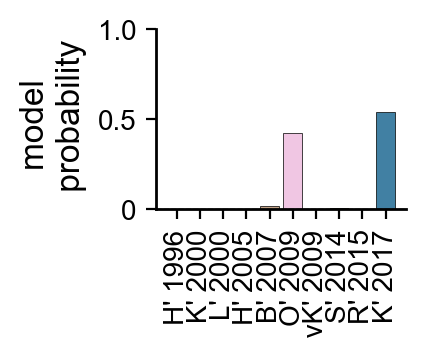

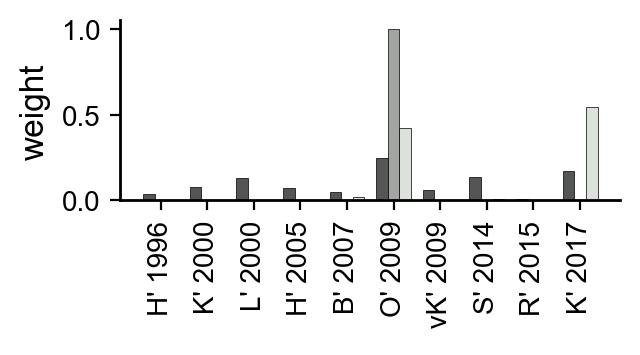

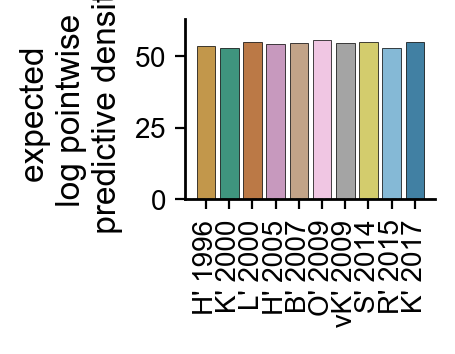

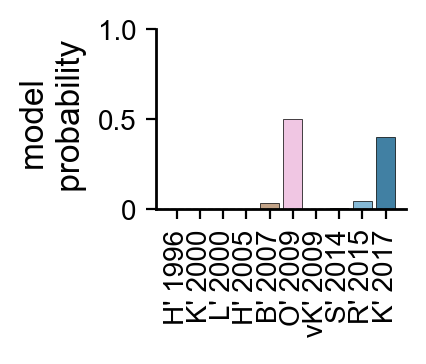

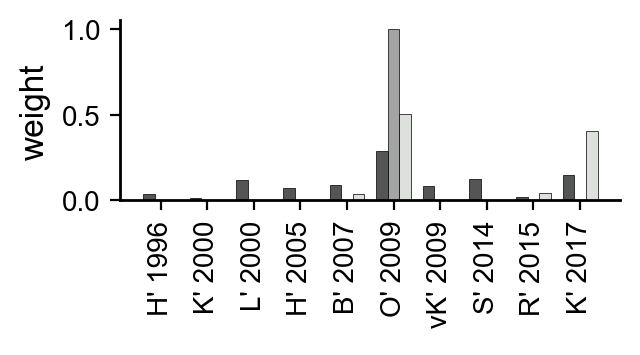

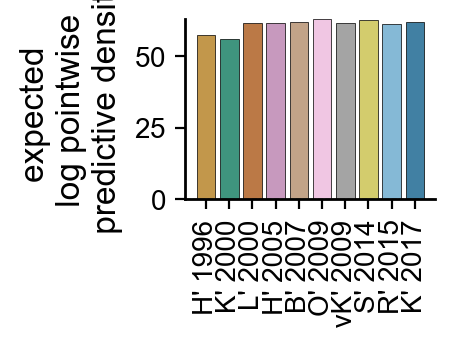

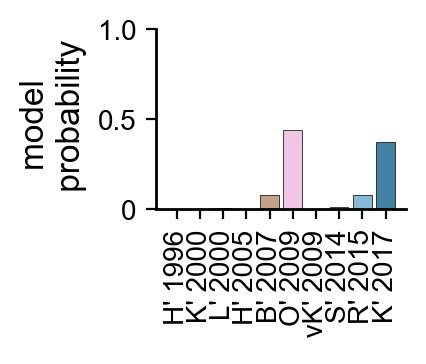

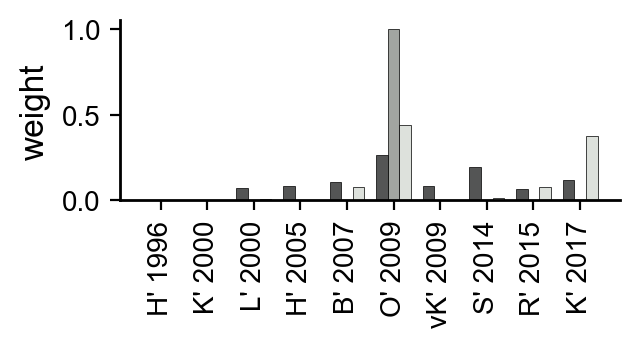

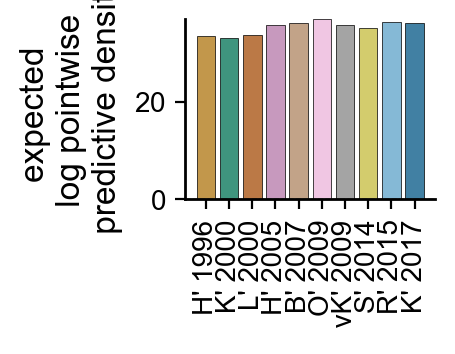

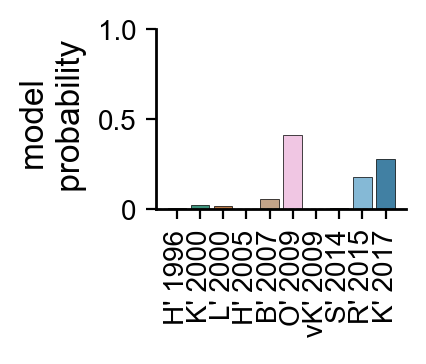

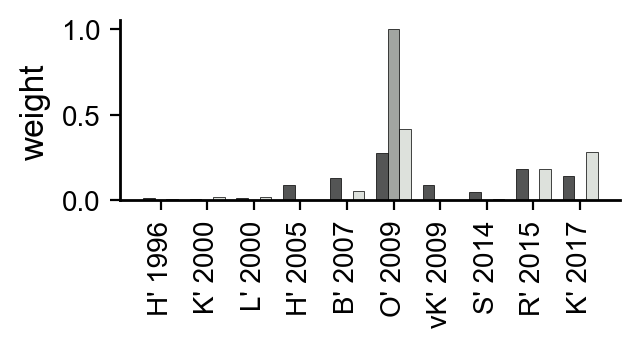

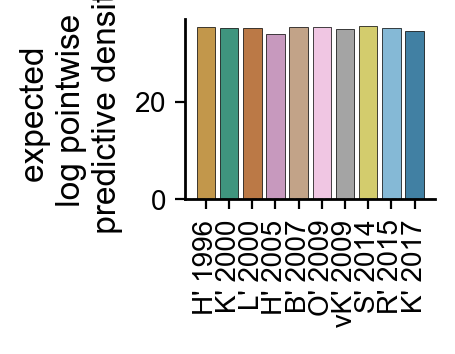

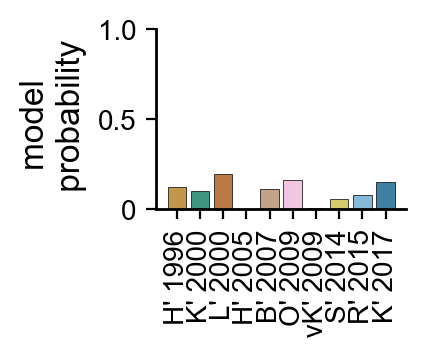

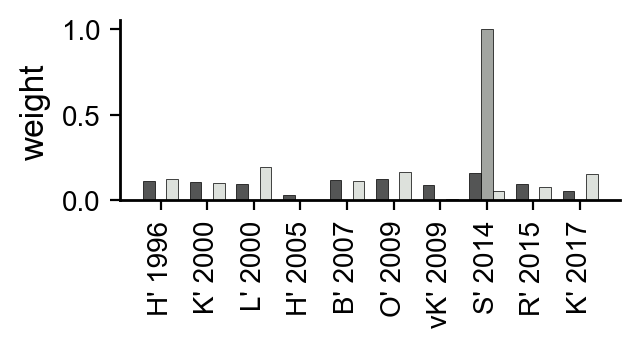

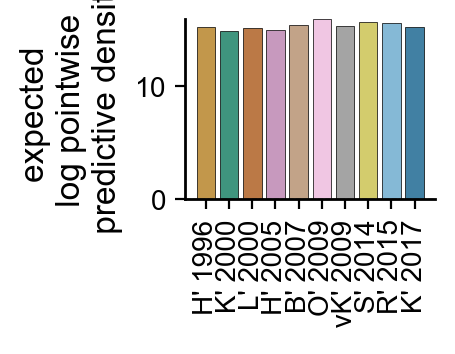

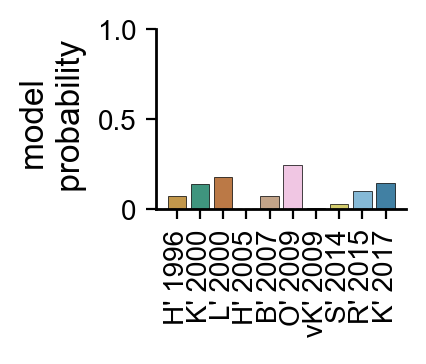

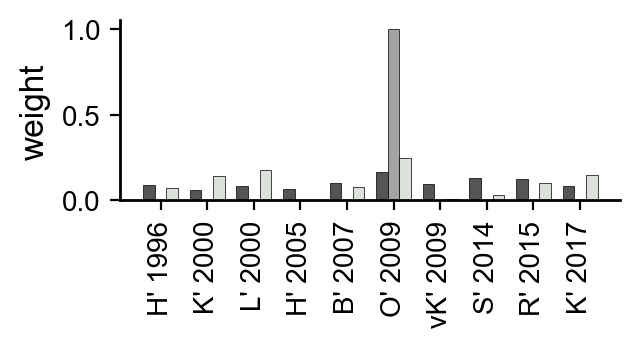

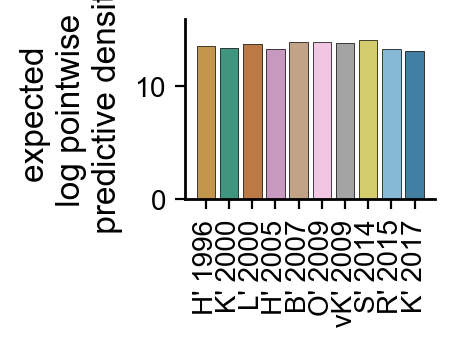

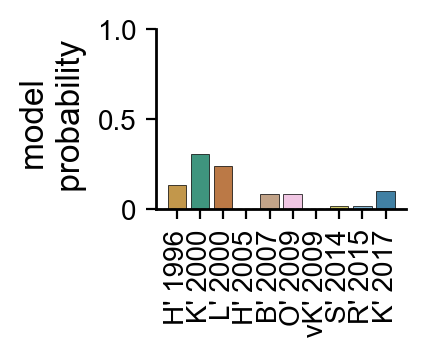

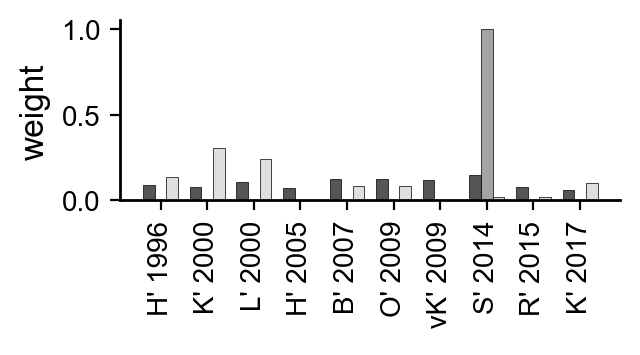

In [5]:
for time_len in ['', '_30min', '_20min', '_10min']:
    print(time_len)
    savedir = '../../../results/MAPK/mmi/Keyes_2020_data'+time_len+'/'
    if time_len == '':
        key = '40min'
    else:
        key = time_len.strip('_')
    ##### make plot of ELPPD, model probabilities, and model weights ######
    # get ylims for all plots
    ylim = [0, 0]
    for compartment in ['CYTO','PM']:
        dat = [elpd_ests[key][compartment]['loo_pbma'][model] for model in model_names]
        
        if np.min(dat) < ylim[0]:
            ylim[0] = np.min(dat)
        if np.max(dat) > ylim[1]:
            ylim[1] = np.max(dat)
    
    for compartment in ['CYTO','PM']: 
        # make a plot of elpd_loo, and elpd_waic
        dat = [elpd_ests[key][compartment]['loo_pbma'][model] for model in model_names]
        fig, ax = get_sized_fig_ax(1.25, 0.9)
        bar = ax.bar(model_names, dat, edgecolor='k', alpha=0.85)
        ax.set_ylabel('expected \n log pointwise \n predictive density', fontsize=12)
        ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
        for i, br in enumerate(bar):
            br.set_facecolor(colors[i])
        xlim = ax.get_xlim()
        ax.plot(xlim, [0,0], '--k', linewidth=0.5)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        # ylim = ax.get_ylim()
        # ax.set_ylim(-0.04*ylim[1], 0.5*ylim[1])
        # ax.set_yticks([0, 200.0])
        # ax.set_yticklabels([0, 200.0], fontsize=10.0)
        fig.savefig(savedir + compartment + '_traj_elpd_loo.pdf', transparent=True)

        # export to csv for source data
        if time_len == '':
            dat_df = pd.DataFrame({'models': display_names, 'elpd_loo': dat})
            dat_df.to_csv(savedir + compartment + '_traj_elpd_loo.csv', index=False)

        # model probabilities
        fig, ax = get_sized_fig_ax(1.25, 0.9)
        bar = ax.bar(model_names, [mmi_weights[key][compartment]['bma'][model] for model in model_names], edgecolor='k', alpha=0.85)
        for i, br in enumerate(bar):
            br.set_facecolor(colors[i])

        ax.set_ylabel('model \n probability', fontsize=12)
        xlim = ax.get_xlim()
        ax.plot(xlim, [0,0], '--k', linewidth=0.5)
        ax.set_xlim(xlim)
        ax.set_ylim([0, 1.0])
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_yticklabels([0, 0.5, 1.0], fontsize=10.0)
        ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
        # ax.set_ylim([0, 1.0])
        fig.savefig(savedir + compartment + '_traj_model_probs.pdf', transparent=True)

        # export to csv for source data
        if time_len == '':
            dat_df = pd.DataFrame({'models': display_names, 'model_prob': [mmi_weights[key][compartment]['bma'][model] for model in model_names]})
            dat_df.to_csv(savedir + compartment + '_traj_model_probs.csv', index=False)

        # model weights stacked bar charts
        x = np.arange(n_models)  # the label locations
        width = 0.25  # the width of the bars
        multiplier = 0

        stack = [mmi_weights[key][compartment]['loo_stack'][model] for model in model_names]
        pBMA = [mmi_weights[key][compartment]['loo_pbma'][model] for model in model_names]
        bma = [mmi_weights[key][compartment]['bma'][model] for model in model_names]

        fig, ax = get_sized_fig_ax(2.5, 0.9)
        for dat, name, col in zip([pBMA, stack, bma], ['pseudo-BMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
            offset = width * multiplier
            bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k', alpha=0.85)
            # ax.bar_label(bar, padding=3)
            multiplier += 1

        ax.set_ylabel('model weight', fontsize=12)
        ax.set_xticks(x + width, display_names)
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=10.0)
        leg = ax.legend(loc='center', fontsize=8.0, bbox_to_anchor=(0.5, 1.3), ncol=1)
        leg.remove()

        ax.set_ylabel(r'weight', fontsize=12)
        ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
        # ax.set_ylim([0, 1.0])
        fig.savefig(savedir + compartment + '_traj_model_weights.pdf', transparent=True)

        # export to csv for source data
        if time_len == '':
            dat_df = pd.DataFrame({'models': display_names, 'stacking': stack, 'pBMA': pBMA, 'BMA': bma})
            dat_df.to_csv(savedir + compartment + '_traj_model_weights.csv', index=False)
# plt.close('all')

In [6]:
dat_c = {model:elpd_ests['40min']['CYTO']['loo_pbma'][model] for model in model_names}
dat_pm = {model:elpd_ests['40min']['PM']['loo_pbma'][model] for model in model_names}

print('CYTO')
sorted_dat_c = sorted(dat_c.items(), key=lambda x: x[1])
for key, value in sorted_dat_c:
    print(key, value)

print('PM')
sorted_dat = sorted(dat_pm.items(), key=lambda x: x[1])
for key, value in sorted_dat:
    print(key, value)

CYTO
ryu_2015 73.40492304964557
kholodenko_2000 74.54643079896124
hornberg_2005 75.63623791148736
huang_ferrell_1996 75.98510397559998
shin_2014 76.04744486718194
birtwistle_2007 76.37834480989045
vonKriegsheim_2009 76.58989563757608
levchenko_2000 76.67698427079564
kochanczyk_2017 76.77462252225078
orton_2009 77.70797443962883
PM
ryu_2015 93.08083720245479
huang_ferrell_1996 95.22437072474034
birtwistle_2007 95.5126219044753
vonKriegsheim_2009 95.70004324972838
hornberg_2005 95.83693773784098
kholodenko_2000 95.94097081378234
levchenko_2000 96.47778172139337
shin_2014 96.4909485203367
kochanczyk_2017 96.74268227431162
orton_2009 97.1283643481338


#### Generate posterior predictive samples and plot MMI traces

/Users/natetest/Library/CloudStorage/Dropbox/Mac (2)/Documents/phd/research/Project_4_multimodel-inference/src/MAPK/multimodel_inference/../plotting_helper_funcs.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(fig_width, fig_height))
/Users/natetest/Library/CloudStorage/Dropbox/Mac (2)/Documents/phd/research/Project_4_multimodel-inference/src/MAPK/multimodel_inference/../utils.py:974: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(trajectory)


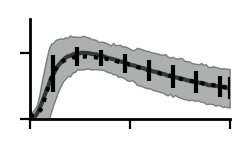

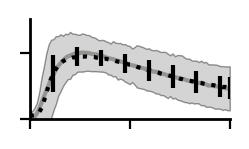

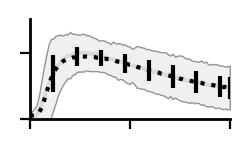

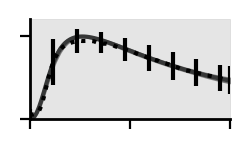

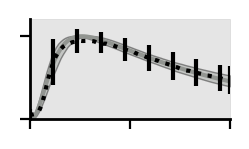

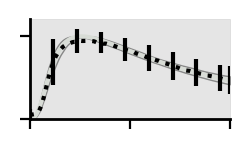

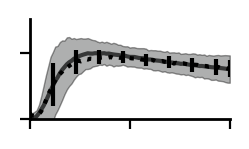

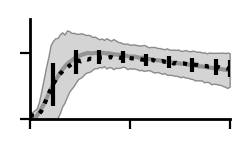

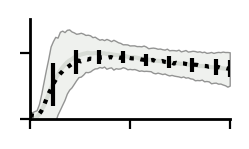

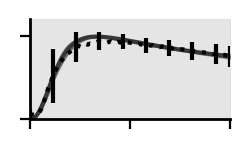

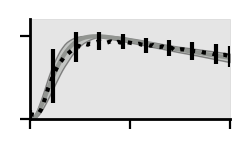

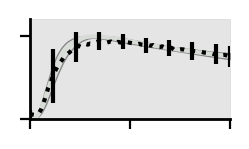

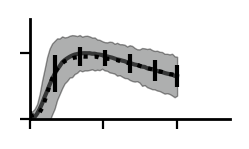

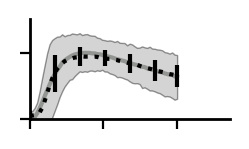

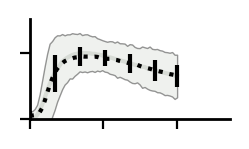

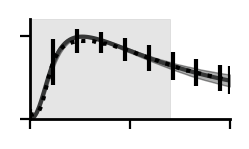

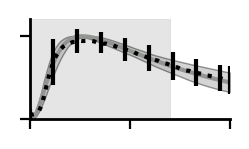

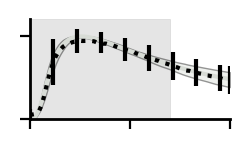

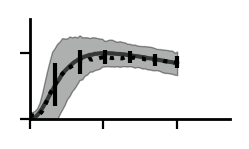

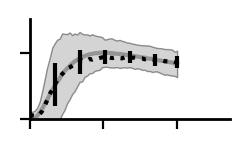

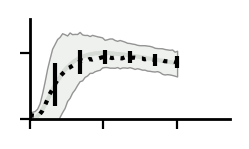

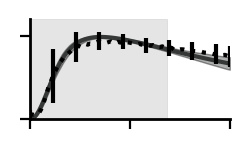

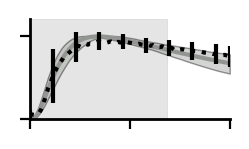

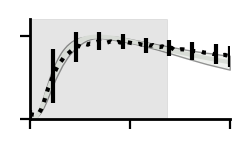

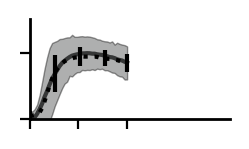

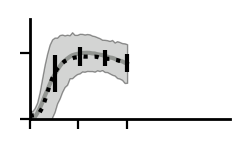

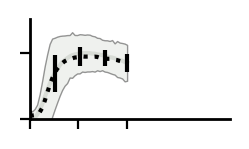

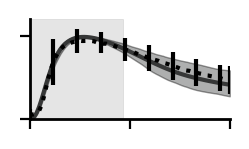

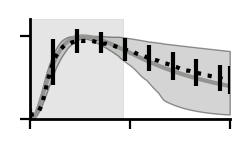

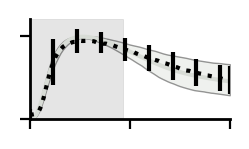

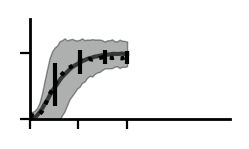

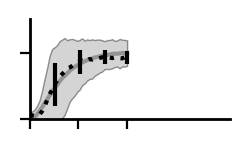

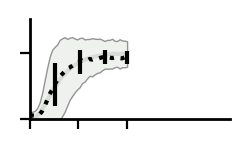

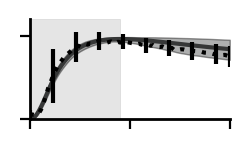

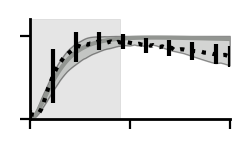

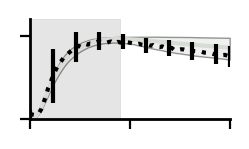

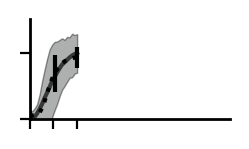

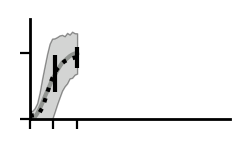

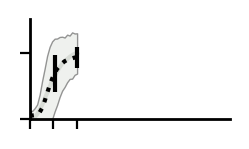

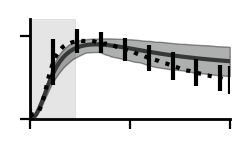

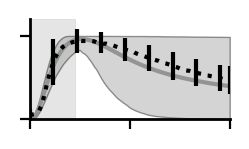

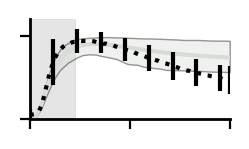

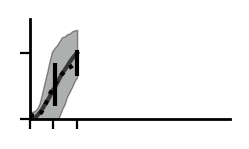

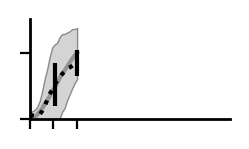

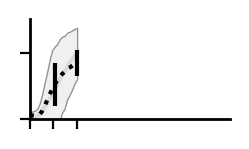

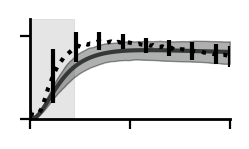

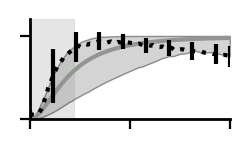

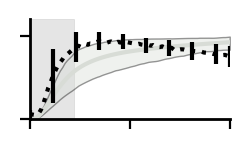

In [7]:
# big dictionaries to save MMI errors and uncertainties
mmi_errors = {'40min':{},'30min':{},'20min':{},'10min':{}}
mmi_uncertainties = {'40min':{},'30min':{},'20min':{},'10min':{}}
mmi_SAM40 = {'40min':{},'30min':{},'20min':{},'10min':{}}
mmi_SAM40_post_pred = {'CYTO':{},'PM':{}}

for time_len in ['', '_30min', '_20min', '_10min']:
    savedir = '../../../results/MAPK/mmi/Keyes_2020_data'+time_len+'/'
    if time_len == '':
        key = '40min'
    else:
        key = time_len.strip('_')

    # first with posterior predictive samples
    loo_bma_combined = {}
    loo_stack_combined = {}
    loo_pbma_combined = {}
    loo_bma_combined_post = {}
    loo_stack_combined_post = {}
    loo_pbma_combined_post = {}
    trajs_mmi_ppc = {'CYTO':{},'PM':{}}
    trajs_mmi_post = {'CYTO':{},'PM':{}}
    errors = {'CYTO':{},'PM':{}}
    uncertainties = {'CYTO':{},'PM':{}}
    SAM40_pred = {'CYTO':{},'PM':{}}

    for compartment in ['CYTO','PM']:
        # posterior predictive
        loo_pbma_combined[compartment] = np.zeros_like(post_pred_samples[key][compartment]['kholodenko_2000'])
        loo_stack_combined[compartment] = np.zeros_like(post_pred_samples[key][compartment]['kholodenko_2000'])
        loo_bma_combined[compartment] = np.zeros_like(post_pred_samples[key][compartment]['kholodenko_2000'])

        # posterior push forward
        loo_pbma_combined_post[compartment] = np.zeros_like(post_samples[key][compartment]['kholodenko_2000'])
        loo_stack_combined_post[compartment] = np.zeros_like(post_samples[key][compartment]['kholodenko_2000'])
        loo_bma_combined_post[compartment] = np.zeros_like(post_samples[key][compartment]['kholodenko_2000'])

        for i, name in enumerate(model_names):
            loo_pbma_combined[compartment] += mmi_weights[key][compartment]['loo_pbma'][name]*post_pred_samples[key][compartment][name]
            loo_stack_combined[compartment] += mmi_weights[key][compartment]['loo_stack'][name]*post_pred_samples[key][compartment][name]
            loo_bma_combined[compartment] += mmi_weights[key][compartment]['bma'][name]*post_pred_samples[key][compartment][name]

            loo_pbma_combined_post[compartment] += mmi_weights[key][compartment]['loo_pbma'][name]*post_samples[key][compartment][name]
            loo_stack_combined_post[compartment] += mmi_weights[key][compartment]['loo_stack'][name]*post_samples[key][compartment][name]
            loo_bma_combined_post[compartment] += mmi_weights[key][compartment]['bma'][name]*post_samples[key][compartment][name]

        
        trajs_mmi_ppc[compartment] = {
            'pseudo-BMA': loo_pbma_combined[compartment],
            'stacking': loo_stack_combined[compartment],
            'BMA': loo_bma_combined[compartment]
        }

        trajs_mmi_post[compartment] = {
            'pseudo-BMA': loo_pbma_combined_post[compartment],
            'stacking': loo_stack_combined_post[compartment],
            'BMA': loo_bma_combined_post[compartment]
        }


        # posterior predictive plots
        cols = [colors[-3], colors[-2], colors[-1]]
        for idx, name in enumerate(trajs_mmi_ppc[compartment].keys()):
            plot_posterior_trajectories(trajs_mmi_ppc[compartment][name], training_data[key][compartment]['data'], training_data[key][compartment]['data_std'], 
                                        training_data[key][compartment]['times'], cols[idx], training_data[key][compartment]['inputs'], 
                                        savedir + compartment, name, data_time_to_mins=60,
                                                    width=1., height=0.5, 
                                                    data_downsample=10,
                                                    ylim=[[0.0, 1.5]],
                                                    y_ticks=[[0.0, 1.0]],
                                                    fname='_mmi_traj_', 
                                                    labels=False, xlim=[0,40])
            
        # posterior push forward plots with training/testing demarcation
        for idx, name in enumerate(trajs_mmi_ppc[compartment].keys()):
             plot_posterior_trajectories(trajs_mmi_post[compartment][name], data[compartment]['data'], data[compartment]['data_std'], 
                                            data[compartment]['times'], cols[idx], 
                                            data[compartment]['inputs'], savedir+compartment,name, data_time_to_mins=60,
                                            width=1., height=0.5, 
                                            data_downsample=10,
                                            ylim=[[0.0, 1.2], [0.0, 1.2], [0.0, 1.2]],
                                            y_ticks=[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]],
                                            fname='_pred_traj_', labels=False, train_times=training_data[key][compartment]['times']/data_time_to_mins)
             
             post_df = pd.DataFrame({'Time (min)': training_data['40min'][compartment]['times']/data_time_to_mins, 
                                    'Mean Response': np.nanmean(trajs_mmi_post[compartment][name], axis=0), 
                                    '2.5th':np.nanpercentile(trajs_mmi_post[compartment][name], 2.5, axis=0), 
                                    '97.5th':np.nanpercentile(trajs_mmi_post[compartment][name], 97.5, axis=0)})
             
             post_df.to_csv(savedir+compartment+name+'_pred_traj.csv', index=False)
        
        # compute errors and uncertainties
        for name in trajs_mmi_ppc[compartment].keys():
            # error on final 10mins of sim time
            idx_30_min = np.argmin(abs((data[compartment]['times']/data_time_to_mins)-30))
            dat_final_10_min = data[compartment]['data'][idx_30_min:]
            pred_final_10_min = trajs_mmi_post[compartment][name][:,idx_30_min:]
            RMSE_final_10_min = np.sqrt(np.nanmean((np.nanmean(
                pred_final_10_min,axis=0) - dat_final_10_min)**2))
            rel_err_final_10_min = np.linalg.norm(np.nanmean(
                pred_final_10_min,axis=0) - dat_final_10_min)/np.linalg.norm(dat_final_10_min)
            cred95_final_10_min = np.nanmean(np.squeeze(np.diff(np.nanquantile(
                pred_final_10_min, [0.025, 0.975], axis=0),axis=0)))
            std_final_10_min = np.nanmean(np.nanstd(pred_final_10_min, axis=0))

            if key == '40min':
                # for the 40min case, we only compute error and uncertainty over all of the data
                # using both ppc and posterior push forward samples
                # error posterior samples
                RMSE = np.sqrt(np.nanmean((np.nanmean(trajs_mmi_post[compartment][name],axis=0) - training_data[key][compartment]['data'])**2))
                rel_err = np.linalg.norm(np.nanmean( 
                    trajs_mmi_post[compartment][name],axis=0) - training_data[key][compartment]['data'])/np.linalg.norm(
                    training_data[key][compartment]['data'])
                cred95 = np.nanmean(np.squeeze(np.diff(np.nanquantile(trajs_mmi_post[compartment][name], [0.025, 0.975], axis=0),axis=0)))
                std = np.nanmean(np.nanstd(trajs_mmi_post[compartment][name], axis=0))

                # error posterior predictive samples
                RMSE_postpred = np.sqrt(np.nanmean((np.nanmean(
                    trajs_mmi_ppc[compartment][name],axis=0) - \
                    training_data[key][compartment]['data'])**2))
                rel_err_postpred = np.linalg.norm(np.nanmean(
                    trajs_mmi_ppc[compartment][name],axis=0) - \
                    training_data[key][compartment]['data'])/np.linalg.norm(training_data[key][compartment]['data'])
                cred95_postpred = np.nanmean(np.squeeze(np.diff(np.nanquantile(
                    trajs_mmi_ppc[compartment][name], [0.025, 0.975], axis=0),axis=0)))
                std_postpred = np.nanmean(np.nanstd(
                    trajs_mmi_ppc[compartment][name], axis=0))
                
                errors[compartment][name] = {'RMSE':RMSE, 'rel_err':rel_err,'RMSE_postpred':RMSE_postpred, 'rel_err_postpred':rel_err_postpred,  'RMSE_final_10_min':RMSE_final_10_min, 'rel_err_final_10_min':rel_err_final_10_min}
                uncertainties[compartment][name] = {'cred95':cred95, 'std':std,'cred95_postpred':cred95_postpred, 'std_postpred':std_postpred, 'cred95_final_10_min':cred95_final_10_min, 'std_final_10_min':std_final_10_min}

                # SAM40 for post preds
                idx_40_min = -1
                SAM40_preds = np.apply_along_axis(sustained_activity_metric, 1, trajs_mmi_ppc[compartment][name], idx_40_min)
                SAM40_post_pred[compartment][name] = list(SAM40_preds)
            else:
                # for all of the other cases compute training error and testing
                #   error using posterior push forward samples
                
                # get index where training data ends
                train_end_idx = np.where(data[compartment]['times'] == training_data[key][compartment]['times'][-1])[0][0]

                # training error
                train_preds = trajs_mmi_post[compartment][name][:,:train_end_idx+1]
                train_data = training_data[key][compartment]['data']
                RMSE_train = np.sqrt(np.nanmean((np.nanmean(train_preds,axis=0) - train_data)**2))
                rel_err_train = np.linalg.norm(np.nanmean(train_preds,axis=0) - train_data)/np.linalg.norm(train_data)
                cred95_train = np.nanmean(np.squeeze(np.diff(np.nanquantile(train_preds, [0.025, 0.975], axis=0),axis=0)))
                std_train = np.nanmean(np.nanstd(train_preds, axis=0))
                
                # testing error
                test_preds = trajs_mmi_post[compartment][name][:,train_end_idx+1:]
                test_data = data[compartment]['data'][train_end_idx+1:]
                RMSE_test = np.sqrt(np.nanmean((np.nanmean(test_preds,axis=0) - test_data)**2))
                rel_err_test = np.linalg.norm(np.nanmean(test_preds,axis=0) - test_data)/np.linalg.norm(test_data)
                cred95_test = np.nanmean(np.squeeze(np.diff(np.nanquantile(test_preds, [0.025, 0.975], axis=0),axis=0)))
                std_test = np.nanmean(np.nanstd(test_preds, axis=0))

                # full data error
                RMSE_full_data = np.sqrt(np.nanmean((np.nanmean(trajs_mmi_post[compartment][name],axis=0) - data[compartment]['data'])**2))
                rel_err_full_data = np.linalg.norm(np.nanmean(trajs_mmi_post[compartment][name],axis=0) - data[compartment]['data'])/np.linalg.norm(data[compartment]['data'])
                cred95_full_data = np.nanmean(np.squeeze(np.diff(np.nanquantile(trajs_mmi_post[compartment][name], [0.025, 0.975], axis=0),axis=0)))
                std_full_data = np.nanmean(np.nanstd(trajs_mmi_post[compartment][name], axis=0))

                errors[compartment][name] = {'RMSE_train':RMSE_train, 'rel_err_train':rel_err_train, 'RMSE_test':RMSE_test, 'rel_err_test':rel_err_test, 'RMSE_full_data':RMSE_full_data, 'rel_err_full_data':rel_err_full_data, 'RMSE_final_10_min':RMSE_final_10_min, 'rel_err_final_10_min':rel_err_final_10_min}

                uncertainties[compartment][name] = {'cred95_train':cred95_train, 'std_train':std_train, 'cred95_test':cred95_test, 'std_test':std_test, 'cred95_full_data':cred95_full_data, 'std_full_data':std_full_data, 'cred95_final_10_min':cred95_final_10_min, 'std_final_10_min':std_final_10_min}

            # SAM40 computation for all
            # compute SAM40 predictions
            idx_40_min = -1
            SAM40_preds = np.apply_along_axis(sustained_activity_metric, 1, trajs_mmi_post[compartment][name], idx_40_min)
            SAM40_pred[compartment][name] = list(SAM40_preds)

    mmi_errors[key] = errors
    mmi_uncertainties[key] = uncertainties
    mmi_SAM40[key] = SAM40_pred

#### Plot errrors and uncertainties for posterior predictive samples (ie only over training times)

In [8]:
# load in the error data
model_errors = {'40min':{},'30min':{},'20min':{},'10min':{}}
model_uncertainties = {'40min':{},'30min':{},'20min':{},'10min':{}}

for time_len in ['', '_30min', '_20min', '_10min']:
    if time_len == '':
        key = '40min'
    else:
        key = time_len.strip('_')
    datadir = '../../../results/MAPK/param_est/Keyes_2020_data'+time_len+'/'
    
    # load stuff
    model_errors[key] = json.load(open(datadir + 'train_test_errors.json', 'r'))
    model_uncertainties[key] = json.load(open(datadir + 'train_test_uncertainty.json', 'r'))

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/2780374577.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/2780374577.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/2780374577.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


../../../results/MAPK/mmi/Keyes_2020_data/CYTO RMSE (np.float64(0.0), np.float64(0.055168154089005876))
0.6307086677134548
../../../results/MAPK/mmi/Keyes_2020_data/CYTO 95 (np.float64(0.0), np.float64(0.6777062460545311))
../../../results/MAPK/mmi/Keyes_2020_data/CYTO RMSE (np.float64(0.0), np.float64(0.0549526023582159))
0.10714353695208431
../../../results/MAPK/mmi/Keyes_2020_data/CYTO 95 (np.float64(0.0), np.float64(0.2))
../../../results/MAPK/mmi/Keyes_2020_data/PM RMSE (np.float64(0.0), np.float64(0.05697610976591178))
0.5253147767394422
../../../results/MAPK/mmi/Keyes_2020_data/PM 95 (np.float64(0.0), np.float64(0.5638148677611573))
../../../results/MAPK/mmi/Keyes_2020_data/PM RMSE (np.float64(0.0), np.float64(0.05758755436163587))


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/2780374577.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/2780374577.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/2780374577.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/2780374577.py:51: Us

0.09353009573395453
../../../results/MAPK/mmi/Keyes_2020_data/PM 95 (np.float64(0.0), np.float64(0.2))


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/2780374577.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


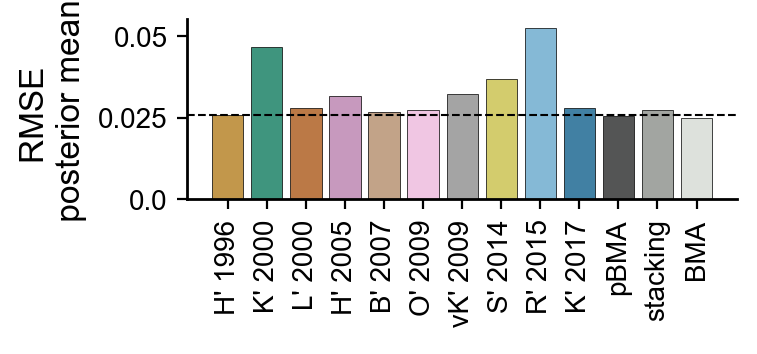

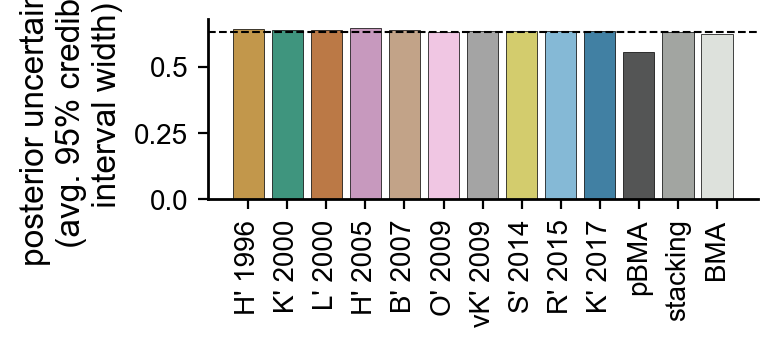

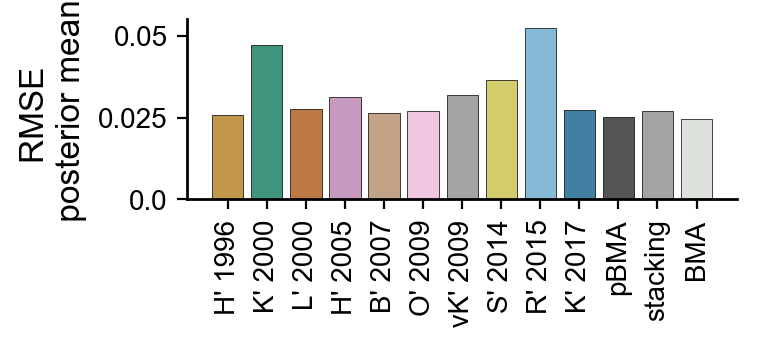

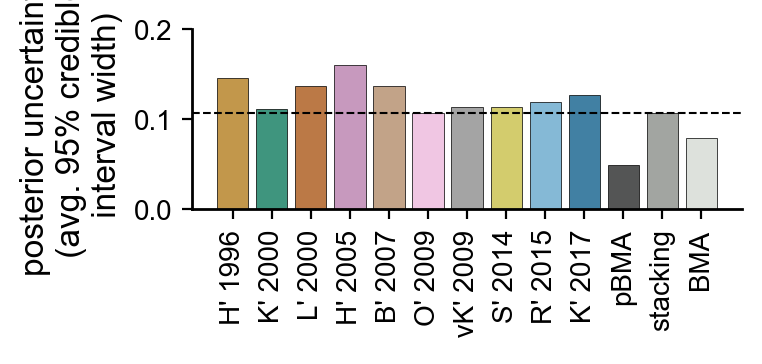

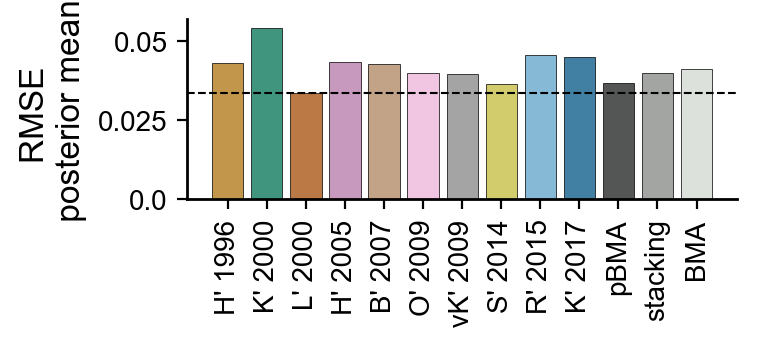

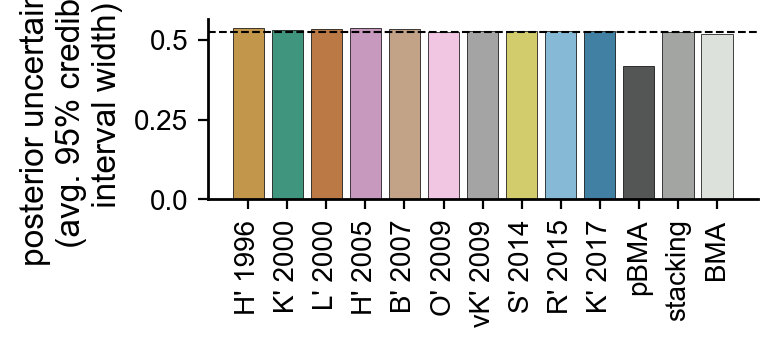

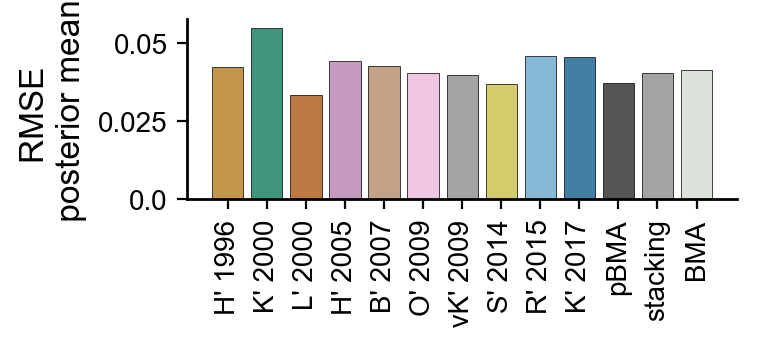

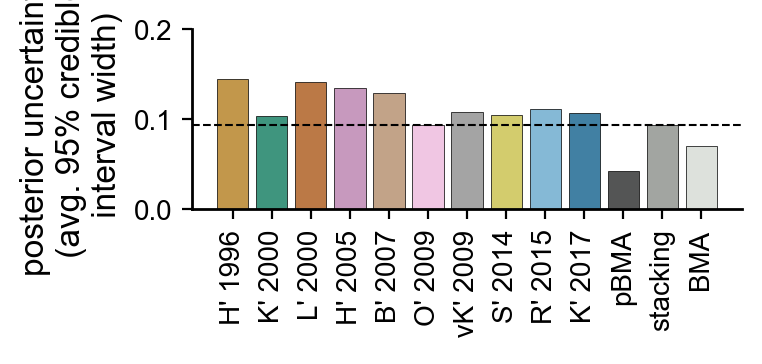

In [14]:
# for full data case, plot error and uncertainty for PPC and posterior push forward
savedir = '../../../results/MAPK/mmi/Keyes_2020_data/'
    
for compartment in ['CYTO','PM']:
    
    RMSE_postpred = [model_errors['40min'][compartment]['RMSE_postpred'][model] for model in model_names] + [mmi_errors['40min'][compartment][name]['RMSE_postpred'] for name in mmi_errors['40min'][compartment].keys()]
    uncert95_postpred = [model_uncertainties['40min'][compartment]['cred95_postpred'][model] for model in model_names] + [mmi_uncertainties['40min'][compartment][name]['cred95_postpred'] for name in mmi_uncertainties['40min'][compartment].keys()]
    RMSE = [model_errors['40min'][compartment]['RMSE'][model] for model in model_names] + [mmi_errors['40min'][compartment][name]['RMSE'] for name in mmi_errors['40min'][compartment].keys()]
    uncert95 = [model_uncertainties['40min'][compartment]['cred95'][model] for model in model_names] + [mmi_uncertainties['40min'][compartment][name]['cred95'] for name in mmi_uncertainties['40min'][compartment].keys()]

    # make plots
    min_index_RMSE = np.argmin(RMSE_postpred[0:8])
    fig, ax = get_sized_fig_ax(2.75, 0.9)
    bar = ax.bar(display_names + ['pBMA', 'stacking', 'BMA'], RMSE_postpred, edgecolor='k', alpha=0.85)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
    
    xlim = ax.get_xlim()
    ax.plot(xlim, [RMSE_postpred[min_index_RMSE]]*2, 'k--', linewidth=0.75)
    ax.set_xlim(xlim)
    ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
    ax.set_ylabel('RMSE \n posterior mean ', fontsize=12.0)
    ax.set_yticks([0.0, 0.025, 0.05])
    ax.set_yticklabels([0.0, 0.025, 0.05], fontsize=10.0)
    print(savedir + compartment, 'RMSE', ax.get_ylim())
    fig.savefig(savedir + compartment + '_RMSE_postpred.pdf', transparent=True)

    min_index_95 = np.argmin(uncert95_postpred[0:8])
    print(uncert95_postpred[min_index_95])
    fig, ax = get_sized_fig_ax(2.75, 0.9)
    bar = ax.bar(display_names + ['pBMA', 'stacking', 'BMA'], uncert95_postpred, edgecolor='k', alpha=0.85)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
    xlim = ax.get_xlim()
    ax.plot(xlim, [uncert95_postpred[min_index_95]]*2, 'k--', linewidth=0.75)
    ax.set_xlim(xlim)
    ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
    ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=12.0)
    # ax.set_ylim([0, 0.5])
    ax.set_yticks([0.0, 0.25, 0.5])
    ax.set_yticklabels([0.0, 0.25, 0.5], fontsize=10.0)
    print(savedir + compartment, '95', ax.get_ylim())
    fig.savefig(savedir + compartment + '_uncertainty_95_postpred.pdf', transparent=True)

    # make plots
    fig, ax = get_sized_fig_ax(2.75, 0.9)
    bar = ax.bar(display_names + ['pBMA', 'stacking', 'BMA'], RMSE, edgecolor='k', alpha=0.85)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
        
    ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
    ax.set_ylabel('RMSE \n posterior mean ', fontsize=12.0)
    ax.set_yticks([0.0, 0.025, 0.05])
    ax.set_yticklabels([0.0, 0.025, 0.05], fontsize=10.0)
    print(savedir + compartment, 'RMSE', ax.get_ylim())
    fig.savefig(savedir + compartment + '_RMSE.pdf', transparent=True)

    dat_df = pd.DataFrame({'models': display_names + ['pBMA', 'stacking', 'BMA'], 'RMSE': RMSE})
    dat_df.to_csv(savedir + compartment + '_RMSE.csv', index=False)

    min_index_95 = np.argmin(uncert95[0:8])
    print(uncert95[min_index_95])
    fig, ax = get_sized_fig_ax(2.75, 0.9)
    bar = ax.bar(display_names + ['pBMA', 'stacking', 'BMA'], uncert95, edgecolor='k', alpha=0.85)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
    xlim = ax.get_xlim()
    ax.plot(xlim, [uncert95[min_index_95]]*2, 'k--', linewidth=0.75)
    ax.set_xlim(xlim)
    ax.set_xticklabels(display_names + ['pBMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
    ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=12.0)
    # ax.set_ylim([0, 0.5])
    ax.set_yticks([0.0, 0.1, 0.2])
    ax.set_yticklabels([0.0, 0.1, 0.2], fontsize=10.0)
    print(savedir + compartment, '95', ax.get_ylim())
    fig.savefig(savedir + compartment + '_uncertainty_95.pdf', transparent=True)

    dat_df = pd.DataFrame({'models': display_names + ['pBMA', 'stacking', 'BMA'], 'uncert_95': uncert95})
    dat_df.to_csv(savedir + compartment + '_uncert_95.csv', index=False)

In [10]:
testing_errors = {'CYTO':[], 'PM':[]}
testing_uncertainties = {'CYTO':[], 'PM':[]}

final_10_min_errors = {'CYTO':[], 'PM':[]}
final_10_min_uncertainties = {'CYTO':[], 'PM':[]}

for time_len in ['', '_30min', '_20min', '_10min']:
    if time_len == '':
        key = '40min'
    else:
        key = time_len.strip('_')
    savedir = '../../../results/MAPK/mmi/Keyes_2020_data'+time_len+'/'
    
    for compartment in ['CYTO','PM']:
        #### first for testing error and uncertainty (exclude 40min case)
        if key != '40min':
            rel_err_test = [model_errors[key][compartment]['rel_err_test'][model] for model in model_names] + [mmi_errors[key][compartment][name]['rel_err_test'] for name in mmi_errors[key][compartment].keys()]
            uncert95_test = [model_uncertainties[key][compartment]['cred95_test'][model] for model in model_names] + [mmi_uncertainties[key][compartment][name]['cred95_test'] for name in mmi_uncertainties[key][compartment].keys()]

            testing_errors[compartment].append(rel_err_test)
            testing_uncertainties[compartment].append(uncert95_test)

            # make plots
            fig, ax = get_sized_fig_ax(2.75, 0.9)
            bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rel_err_test, edgecolor='k', alpha=0.85)
            for i, br in enumerate(bar):
                br.set_facecolor(colors[i])
                
            ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
            ax.set_ylabel(r'$\frac{||\widehat{y_{\rm test}} - y_{\rm test}||_2}{||y_{\rm test}||_2}$', fontsize=12.0)
            # ax.set_yticks([0.0, 0.025, 0.05])
            # ax.set_yticklabels([0.0, 0.025, 0.05], fontsize=10.0)
            print(savedir + compartment, 'rel_err_test', ax.get_ylim())
            fig.savefig(savedir + compartment + '_rel_err_test.pdf', transparent=True)

            min_index_95 = np.argmin(uncert95_test[0:8])
            print(uncert95_test[min_index_95])
            fig, ax = get_sized_fig_ax(2.5, 0.9)
            bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], uncert95_test, edgecolor='k', alpha=0.85)
            for i, br in enumerate(bar):
                br.set_facecolor(colors[i])
            xlim = ax.get_xlim()
            ax.plot(xlim, [uncert95_test[min_index_95]]*2, 'k--', linewidth=0.75)
            ax.set_xlim(xlim)
            ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
            fig.savefig(savedir + compartment + '_uncert95_test.pdf', transparent=True)
        
        #### now for final 10min of sim time error and uncertainty
        rel_err_final_10_min = [model_errors[key][compartment]['rel_err_final_10_min'][model] for model in model_names] + [mmi_errors[key][compartment][name]['rel_err_final_10_min'] for name in mmi_errors[key][compartment].keys()]
        uncert95_final_10_min = [model_uncertainties[key][compartment]['cred95_final_10_min'][model] for model in model_names] + [mmi_uncertainties[key][compartment][name]['cred95_final_10_min'] for name in mmi_uncertainties[key][compartment].keys()]

        final_10_min_errors[compartment].append(rel_err_final_10_min)
        final_10_min_uncertainties[compartment].append(uncert95_final_10_min)

        # make plots
        fig, ax = get_sized_fig_ax(2.75, 0.9)
        bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rel_err_final_10_min, edgecolor='k', alpha=0.85)
        for i, br in enumerate(bar):
            br.set_facecolor(colors[i])
            
        ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
        ax.set_ylabel(r'$\frac{||\widehat{y_{\rm final 10}} - y_{\rm final 10}||_2}{||y_{\rm final 10}||_2}$', fontsize=12.0)
        # ax.set_yticks([0.0, 0.025, 0.05])
        # ax.set_yticklabels([0.0, 0.025, 0.05], fontsize=10.0)
        print(savedir + compartment, 'rel_err_final_10_min', ax.get_ylim())
        fig.savefig(savedir + compartment + '_rel_err_test.pdf', transparent=True)

        min_index_95 = np.argmin(uncert95_final_10_min[0:8])
        print(uncert95_final_10_min[min_index_95])
        fig, ax = get_sized_fig_ax(2.5, 0.9)
        bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], uncert95_final_10_min, edgecolor='k', alpha=0.85)
        for i, br in enumerate(bar):
            br.set_facecolor(colors[i])
        xlim = ax.get_xlim()
        ax.plot(xlim, [uncert95_final_10_min[min_index_95]]*2, 'k--', linewidth=0.75)
        ax.set_xlim(xlim)
        ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
        fig.savefig(savedir + compartment + '_uncert95_final_10_min.pdf', transparent=True)
plt.close('all')


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


../../../results/MAPK/mmi/Keyes_2020_data/CYTO rel_err_final_10_min (np.float64(0.0), np.float64(0.058795231995534))
0.11772707570484224
../../../results/MAPK/mmi/Keyes_2020_data/PM rel_err_final_10_min (np.float64(0.0), np.float64(0.03138217427812327))
0.07864180028379165


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/15

../../../results/MAPK/mmi/Keyes_2020_data_30min/CYTO rel_err_test (np.float64(0.0), np.float64(0.21116674730366813))
0.20712464892223495
../../../results/MAPK/mmi/Keyes_2020_data_30min/CYTO rel_err_final_10_min (np.float64(0.0), np.float64(0.21116674730366813))
0.20712464892223495
../../../results/MAPK/mmi/Keyes_2020_data_30min/PM rel_err_test (np.float64(0.0), np.float64(0.1866808204566929))
0.18280895988837637


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/15

../../../results/MAPK/mmi/Keyes_2020_data_30min/PM rel_err_final_10_min (np.float64(0.0), np.float64(0.1866808204566929))
0.18280895988837637
../../../results/MAPK/mmi/Keyes_2020_data_20min/CYTO rel_err_test (np.float64(0.0), np.float64(0.6167029781492422))
0.014470448379615477


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/15

../../../results/MAPK/mmi/Keyes_2020_data_20min/CYTO rel_err_final_10_min (np.float64(0.0), np.float64(0.8633476039909173))
0.005877402676585826
../../../results/MAPK/mmi/Keyes_2020_data_20min/PM rel_err_test (np.float64(0.0), np.float64(0.2352216345466967))
0.03874435767117759
../../../results/MAPK/mmi/Keyes_2020_data_20min/PM rel_err_final_10_min (np.float64(0.0), np.float64(0.3140664313845511))
0.01808030129352463


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/Users/natetest/Library/CloudStorage/Dropbox/Mac (2)/Documents/phd/

../../../results/MAPK/mmi/Keyes_2020_data_10min/CYTO rel_err_test (np.float64(0.0), np.float64(0.45312058543584466))
0.12035147990812751
../../../results/MAPK/mmi/Keyes_2020_data_10min/CYTO rel_err_final_10_min (np.float64(0.0), np.float64(0.8672432855811346))
0.01604592732803162
../../../results/MAPK/mmi/Keyes_2020_data_10min/PM rel_err_test (np.float64(0.0), np.float64(0.47639845094478))
0.36077533456821287


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


../../../results/MAPK/mmi/Keyes_2020_data_10min/PM rel_err_final_10_min (np.float64(0.0), np.float64(0.6672492570351987))
0.16217593497905725


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/1515550413.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


0
1
2
3
4
5
6
7
8
9
10
11
12


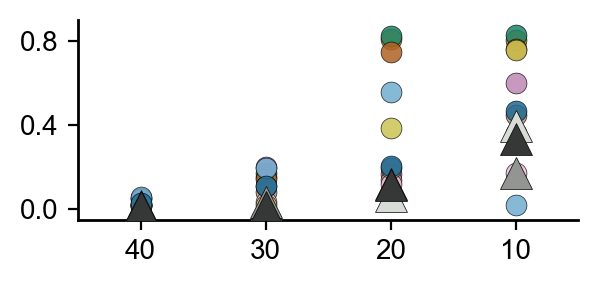

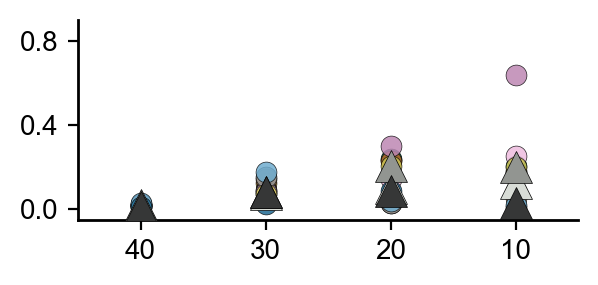

In [11]:
fig, ax = get_sized_fig_ax(2.5, 1.0)
errs = final_10_min_errors['CYTO'].copy()
errs.reverse()
errs = np.array(errs)

labels = display_names + ['pBMA', 'stacking', 'BMA']
for i, col in enumerate(errs.T):
    ln = ax.plot(np.flip(col), 'o', color=colors[i], markersize=7.5, label=labels[i], markeredgecolor= "xkcd:black", markeredgewidth=0.25) 
    if i>9:
        # ln[0].set_linestyle('--')
        ln[0].set_marker("^")
        ln[0].set_markersize("11.5")
        ln[0].set_linewidth(3.5)
        if i==10:
            ln[0].set_zorder(10)
        elif i==11:
            ln[0].set_zorder(9)
        else:
            ln[0].set_zorder(8)
    else:
        ln[0].set_alpha(0.85)

ax.set_xticks(np.arange(4), ['40', '30', '20', '10'], fontsize=10.0)
ax.set_ylim([-0.05, 0.9])
ax.set_xlim([-0.5, 3.5])
ax.set_yticks([0.0, 0.4, 0.8],[0.0, 0.4, 0.8], fontsize=10.0)

xlim = ax.get_xlim()
leg = ax.legend(loc='upper left', fontsize=8.0, bbox_to_anchor=(2.0, 1.0), ncol=2)
export_legend(leg, '../../../results/MAPK/mmi/Keyes_CYTO_final_10_min_rel_err_LEG.pdf')
leg.remove()

fig.savefig('../../../results/MAPK/mmi/Keyes_CYTO_final_10_min_rel_err.pdf', transparent=True)

err_df = pd.DataFrame({
    'models': labels,
    '40': errs[0, :],
    '30': errs[1, :],
    '20': errs[2, :],
    '10': errs[3, :]
})
err_df.to_csv('../../../results/MAPK/mmi/Keyes_CYTO_final_10_min_rel_err.csv', index=False)

fig, ax = get_sized_fig_ax(2.5, 1.0)
errs = final_10_min_errors['PM'].copy()
errs.reverse()
errs = np.array(errs)

labels = display_names + ['pseudo-BMA', 'stacking', 'BMA']
for i, col in enumerate(errs.T):
    print(i)
    ln = ax.plot(np.flip(col), 'o', color=colors[i], markersize=7.5, label=labels[i], markeredgecolor= "xkcd:black", markeredgewidth=0.25) 
    if i>9:
        # ln[0].set_linestyle('--')
        ln[0].set_marker("^")
        ln[0].set_markersize("11.5")
        ln[0].set_linewidth(3.5)
        if i==10:
            ln[0].set_zorder(10)
        elif i==11:
            ln[0].set_zorder(9)
        else:
            ln[0].set_zorder(8)
    else:
        ln[0].set_alpha(0.85)

ax.set_xticks(np.arange(4), ['40', '30', '20', '10'], fontsize=10.0)
ax.set_ylim([-0.05, 0.9])
ax.set_xlim([-0.5, 3.5])
ax.set_yticks([0.0, 0.4, 0.8],[0.0, 0.4, 0.8], fontsize=10.0)

xlim = ax.get_xlim()
fig.savefig('../../../results/MAPK/mmi/Keyes_PM_final_10_min_rel_err.pdf', transparent=True)

err_df = pd.DataFrame({
    'models': labels,
    '40': errs[0, :],
    '30': errs[1, :],
    '20': errs[2, :],
    '10': errs[3, :]
})
err_df.to_csv('../../../results/MAPK/mmi/Keyes_PM_final_10_min_rel_err.csv', index=False)

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/947637084.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ln = ax.plot(np.flip(col), '.', color=colors[i], marker='o', markersize=7.5, label=labels[i], markeredgecolor= "xkcd:black", markeredgewidth=0.25)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_13807/947637084.py:49: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ln = ax.plot(np.flip(col), '.', color=colors[i], marker='o', markersize=7.5, label=labels[i], markeredgecolor= "xkcd:black", markeredgewidth=0.25)


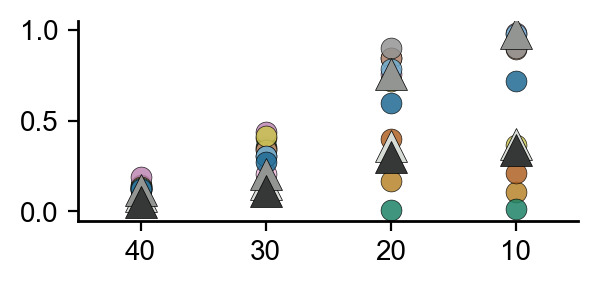

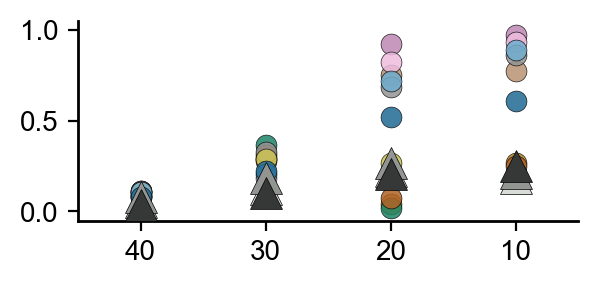

In [12]:
fig, ax = get_sized_fig_ax(2.5, 1.0)
errs = final_10_min_uncertainties['CYTO'].copy()
errs.reverse()
errs = np.array(errs)

labels = display_names + ['pBMA', 'stacking', 'BMA']
for i, col in enumerate(errs.T):
    ln = ax.plot(np.flip(col), '.', color=colors[i], marker='o', markersize=7.5, label=labels[i], markeredgecolor= "xkcd:black", markeredgewidth=0.25) 
    if i>9:
        # ln[0].set_linestyle('--')
        ln[0].set_marker("^")
        ln[0].set_markersize("11.5")
        ln[0].set_linewidth(3.5)
        if i==10:
            ln[0].set_zorder(10)
        elif i==11:
            ln[0].set_zorder(9)
        else:
            ln[0].set_zorder(8)
    else:
        ln[0].set_alpha(0.85)

ax.set_xticks(np.arange(4), ['40', '30', '20', '10'], fontsize=10.0)
ax.set_yticks([0.0, 0.5, 1.0],[0.0, 0.5, 1.0], fontsize=10.0)
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([-0.5, 3.5])
fig.savefig('../../../results/MAPK/mmi/Keyes_CYTO_final_10_min_uncert95.pdf', transparent=True)

err_df = pd.DataFrame({
    'models': labels,
    '40': errs[0, :],
    '30': errs[1, :],
    '20': errs[2, :],
    '10': errs[3, :]
})
err_df.to_csv('../../../results/MAPK/mmi/Keyes_CYTO_final_10_min_uncert95.csv', index=False)

# xlim = ax.get_xlim()
# ax.plot(xlim, [0.1]*2, '--', linewidth=1.0, color='blue', zorder=-1)
# ax.set_xlim(xlim)

fig, ax = get_sized_fig_ax(2.5, 1.0)
errs = final_10_min_uncertainties['PM'].copy()
errs.reverse()
errs = np.array(errs)

labels = display_names + ['pBMA', 'stacking', 'BMA']
for i, col in enumerate(errs.T):
    ln = ax.plot(np.flip(col), '.', color=colors[i], marker='o', markersize=7.5, label=labels[i], markeredgecolor= "xkcd:black", markeredgewidth=0.25) 
    if i>9:
        # ln[0].set_linestyle('--')
        ln[0].set_marker("^")
        ln[0].set_markersize("11.5")
        ln[0].set_linewidth(3.5)
        if i==10:
            ln[0].set_zorder(10)
        elif i==11:
            ln[0].set_zorder(9)
        else:
            ln[0].set_zorder(8)
    else:
        ln[0].set_alpha(0.85)

ax.set_xticks(np.arange(4), ['40', '30', '20', '10'], fontsize=10.0)
ax.set_yticks([0.0, 0.5, 1.0],[0.0, 0.5, 1.0], fontsize=10.0)
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([-0.5, 3.5])
fig.savefig('../../../results/MAPK/mmi/Keyes_PM_final_10_min_uncert95.pdf', transparent=True)

leg = ax.legend(loc='upper left', fontsize=8.0, bbox_to_anchor=(2.0, 1.0), ncol=2, 
                numpoints=1, handletextpad=-0.25, columnspacing=0.0)
export_legend(leg, '../../../results/MAPK/mmi/Keyes_PM_final_10_min_rel_err_LEG.pdf')
leg.remove()

err_df = pd.DataFrame({
    'models': labels,
    '40': errs[0, :],
    '30': errs[1, :],
    '20': errs[2, :],
    '10': errs[3, :]
})
err_df.to_csv('../../../results/MAPK/mmi/Keyes_PM_final_10_min_uncert95.csv', index=False)

Compute mean final 10 min rel errors and uncertainties for each model

In [13]:
errs = final_10_min_errors['CYTO'].copy()
errs = np.array(errs)
print('The model with lowest cytoplasm error is:')
print(display_names[np.argmin(np.mean(errs, axis=0)[0:8])]) # note only do first 8, because the last 3 are the mmi methods

errs = final_10_min_errors['PM'].copy()
errs = np.array(errs)
print('The model with lowest PM error is:')
print(display_names[np.argmin(np.mean(errs, axis=0)[0:8])]) # note only do first 8, because the last 3 are the mmi methods


The model with lowest cytoplasm error is:
O' 2009
The model with lowest PM error is:
 vK' 2009
